# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
# IMPORTANT: RUN THIS CELL FOR EVERY EXERCISE

import glob
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

PATH_FOLDER = "../../Arsalan/Homework 1/Data"
PATH_GUINEA = PATH_FOLDER + "/ebola/guinea_data"
PATH_LIBERIA = PATH_FOLDER + "/ebola/liberia_data"
PATH_SL = PATH_FOLDER + "/ebola/sl_data"

PATH_MICROBIOME = PATH_FOLDER + "/microbiome"

na_val=['?', 'NaN', 'NA', 'Na', 'na', 'nan', 'Nan']

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [2]:
# Import all files and put them into df

files_guinea = glob.glob(PATH_GUINEA + "/*.csv")
data_guinea_array = [pd.read_csv(f, na_values=na_val) for f in files_guinea]
data_guinea = pd.concat(data_guinea_array, ignore_index=True)
data_guinea['Country'] = "Guinea"
data_guinea['Year'] = [[int(s) for s in val.split('-') if s.isdigit()][0] for val in data_guinea['Date']]
data_guinea['Month'] = [[int(s) for s in val.split('-') if s.isdigit()][1] for val in data_guinea['Date']]
data_guinea['Day'] = [[int(s) for s in val.split('-') if s.isdigit()][2] for val in data_guinea['Date']]

files_liberia = glob.glob(PATH_LIBERIA + "/*.csv")
data_liberia_array = [pd.read_csv(f, na_values=na_val) for f in files_liberia]
data_liberia = pd.concat(data_liberia_array, ignore_index=True)
data_liberia['Country'] = "Liberia"
data_liberia['Year'] = [[int(s) for s in val.split('/') if s.isdigit()][2] for val in data_liberia['Date']]
data_liberia['Month'] = [[int(s) for s in val.split('/') if s.isdigit()][0] for val in data_liberia['Date']]
data_liberia['Day'] = [[int(s) for s in val.split('/') if s.isdigit()][1] for val in data_liberia['Date']]

files_sl = glob.glob(PATH_SL + "/*.csv")
data_sl_array = [pd.read_csv(f, na_values=na_val) for f in files_sl]
data_sl = pd.concat(data_sl_array, ignore_index=True)
data_sl['Country'] = "SierraLeone"
data_sl['Year'] = [[int(s) for s in val.split('-') if s.isdigit()][0] for val in data_sl['date']]
data_sl['Month'] = [[int(s) for s in val.split('-') if s.isdigit()][1] for val in data_sl['date']]
data_sl['Day'] = [[int(s) for s in val.split('-') if s.isdigit()][2] for val in data_sl['date']]

dfList = [data_guinea, data_liberia, data_sl]
df = pd.concat(dfList, ignore_index=True)


# Cleaning data

def mergeColumns(data_frame, column_to_fill, columns_to_empty):
    for column in columns_to_empty:
        data_frame[column_to_fill] = data_frame[column_to_fill].fillna(df[column])
        
mergeColumns(df, 'Description', ['variable', 'Variable'])
mergeColumns(df, 'National', ['Totals'])
mergeColumns(df, 'Police training School', ['Police traning School'])
df = df.drop('variable', axis=1)
df = df.drop('Variable', axis=1)
df = df.drop('Totals', axis=1)
df = df.drop('Date', axis=1)
df = df.drop('date', axis=1)
df = df.drop('Police traning School', axis=1)

cities = list(set(df.columns)-set(['Country', 'Day', 'Month', 'Year', 'Description', 'National']))

df=df.fillna(0)

In [3]:
def avgOverMonth_dataNew(country, description, month):
    # This function will return the average per day of the  given description during the given month in the given country
    # The description must refer to a data which has been collected during the day (for example 2 'new cases today' is valid, 200 'total cases so far' is not)
    value = 0
    if (type(description) == str):
        value = df.query('Description == @description and Month == @month and Country == @country')['National'].astype(dtype=int).mean()
    elif (type(description) == list):
        for desc in description:
            value += avgOverMonth(country, desc, month)
    return value

def avgOverMonth_dataTotal(country, description, month):
    # This function will return the average per day of the  given description during the given month in the given country
    # It is different than the previous function in that the description has to be the total so far (it computes an average during this month)
    firstDay = df.query('Country == @country and Month == @month')['Day'].min()
    lastDay = df.query('Country == @country and Month == @month')['Day'].max()
    if (country == 'SierraLeone' and month == 12):
        lastDay = 6
    firstDayValue = 0
    lastDayValue = 0
    if (type(description) == str):
        firstDayValue = df.query('Description == @description and Day == @firstDay and Country == @country and Month == @month')['National'].astype(dtype=int)[df.query('Description == @description and Day == @firstDay and Country == @country and Month == @month')['National'].index[0]]
        lastDayValue = df.query('Description == @description and Day == @lastDay and Country == @country and Month == @month')['National'].astype(dtype=int)[df.query('Description == @description and Day == @lastDay and Country == @country and Month == @month')['National'].index[0]]
    elif (type(description) == list):
        for desc in description:
            firstDayValue += df.query('Description == @desc and Day == @firstDay and Country == @country and Month == @month')['National'].astype(dtype=int)[df.query('Description == @desc and Day == @firstDay and Country == @country and Month == @month')['National'].index[0]]
            lastDayValue += df.query('Description == @desc and Day == @lastDay and Country == @country and Month == @month')['National'].astype(dtype=int)[df.query('Description == @desc and Day == @lastDay and Country == @country and Month == @month')['National'].index[0]]
    return (lastDayValue - firstDayValue)/(lastDay - firstDay)
    
# All of these are variables to answer the question
    
daily_average_deaths_Guinea_August = avgOverMonth_dataNew('Guinea', 'New deaths registered today', 8)
daily_average_deaths_Guinea_September = avgOverMonth_dataNew('Guinea', 'New deaths registered', 9)
daily_average_deaths_Guinea_October = avgOverMonth_dataNew('Guinea', 'New deaths registered', 10)

daily_average_newCases_Guinea_August = avgOverMonth_dataNew('Guinea', 'Total new cases registered so far', 8)
daily_average_newCases_Guinea_September = avgOverMonth_dataNew('Guinea', 'Total new cases registered so far', 9)
daily_average_newCases_Guinea_October = avgOverMonth_dataNew('Guinea', 'Total new cases registered so far', 10)


daily_average_deaths_Liberia_June = avgOverMonth_dataNew('Liberia', 'Newly reported deaths', 6)
daily_average_deaths_Liberia_July = avgOverMonth_dataNew('Liberia', 'Newly reported deaths', 7)
daily_average_deaths_Liberia_August = avgOverMonth_dataNew('Liberia', 'Newly reported deaths', 8)
daily_average_deaths_Liberia_September = avgOverMonth_dataNew('Liberia', 'Newly reported deaths', 9)
daily_average_deaths_Liberia_October = avgOverMonth_dataNew('Liberia', 'Newly reported deaths', 10)
daily_average_deaths_Liberia_November = avgOverMonth_dataNew('Liberia', 'Newly reported deaths', 11)
daily_average_deaths_Liberia_December = avgOverMonth_dataNew('Liberia', 'Newly reported deaths', 12)

daily_average_newCases_Liberia_June = avgOverMonth_dataNew('Liberia', ['New Case/s (Suspected)', 'New Case/s (Probable)', 'New case/s (confirmed)'], 6)
daily_average_newCases_Liberia_July = avgOverMonth_dataNew('Liberia', ['New Case/s (Suspected)', 'New Case/s (Probable)', 'New case/s (confirmed)'], 7)
daily_average_newCases_Liberia_August = avgOverMonth_dataNew('Liberia', ['New Case/s (Suspected)', 'New Case/s (Probable)', 'New case/s (confirmed)'], 8)
daily_average_newCases_Liberia_September = avgOverMonth_dataNew('Liberia', ['New Case/s (Suspected)', 'New Case/s (Probable)', 'New case/s (confirmed)'], 9)
daily_average_newCases_Liberia_October = avgOverMonth_dataNew('Liberia', ['New Case/s (Suspected)', 'New Case/s (Probable)', 'New case/s (confirmed)'], 10)
daily_average_newCases_Liberia_November = avgOverMonth_dataNew('Liberia', ['New Case/s (Suspected)', 'New Case/s (Probable)', 'New case/s (confirmed)'], 11)
daily_average_newCases_Liberia_December = avgOverMonth_dataNew('Liberia', ['New Case/s (Suspected)', 'New Case/s (Probable)', 'New case/s (confirmed)'], 12)


daily_average_deaths_SL_August = avgOverMonth_dataTotal('SierraLeone', ['death_suspected', 'death_probable', 'death_confirmed'], 8)
daily_average_deaths_SL_September = avgOverMonth_dataTotal('SierraLeone', ['death_suspected', 'death_probable', 'death_confirmed'], 9)
daily_average_deaths_SL_October = avgOverMonth_dataTotal('SierraLeone', ['death_suspected', 'death_probable', 'death_confirmed'], 10)
daily_average_deaths_SL_November = avgOverMonth_dataTotal('SierraLeone', ['death_suspected', 'death_probable', 'death_confirmed'], 11)
daily_average_deaths_SL_December = avgOverMonth_dataTotal('SierraLeone', ['death_suspected', 'death_probable', 'death_confirmed'], 12)

daily_average_newCases_SL_August = avgOverMonth_dataNew('SierraLeone', ['new_suspected', 'new_probable', 'new_confirmed'], 8)
daily_average_newCases_SL_September = avgOverMonth_dataNew('SierraLeone', ['new_suspected', 'new_probable', 'new_confirmed'], 9)
daily_average_newCases_SL_October = avgOverMonth_dataNew('SierraLeone', ['new_suspected', 'new_probable', 'new_confirmed'], 10)
daily_average_newCases_SL_November = avgOverMonth_dataNew('SierraLeone', ['new_suspected', 'new_probable', 'new_confirmed'], 11)
daily_average_newCases_SL_December = avgOverMonth_dataNew('SierraLeone', ['new_suspected', 'new_probable', 'new_confirmed'], 12)


NameError: name 'avgOverMonth' is not defined

In [ ]:
# This is simply to put the variables in a nice and readable dataframe

g='Guinea'
l='Liberia'
sl='Sierra Leone'
ad='Average per day of deaths'
an='Average per day of new cases'
j='June'
J='July'
a='August'
s='September'
o='October'
n='November'
d='December'
dfG=pd.DataFrame({'Country':     [g,g,g,g,g,g],
                  'Description': [ad,ad,ad,an,an,an],
                  'Month':       [a,s,o,a,s,o],
                  'Value':       [daily_average_deaths_Guinea_August, daily_average_deaths_Guinea_September, daily_average_deaths_Guinea_October, daily_average_newCases_Guinea_August, daily_average_newCases_Guinea_September, daily_average_newCases_Guinea_October]})
dfL=pd.DataFrame({'Country':     [l,l,l,l,l,l,l,l,l,l,l,l,l,l],
                  'Description': [ad,ad,ad,ad,ad,ad,ad,an,an,an,an,an,an,an],
                  'Month':       [j,J,a,s,o,n,d,j,J,a,s,o,n,d],
                  'Value':       [daily_average_deaths_Liberia_June, daily_average_deaths_Liberia_July, daily_average_deaths_Liberia_August, daily_average_deaths_Liberia_September, daily_average_deaths_Liberia_October, daily_average_deaths_Liberia_November, daily_average_deaths_Liberia_December, daily_average_newCases_Liberia_June, daily_average_newCases_Liberia_July, daily_average_newCases_Liberia_August, daily_average_newCases_Liberia_September, daily_average_newCases_Liberia_October, daily_average_newCases_Liberia_November, daily_average_newCases_Liberia_December]})
dfSL=pd.DataFrame({'Country':     [sl,sl,sl,sl,sl,sl,sl,sl,sl,sl],
                   'Description': [ad,ad,ad,ad,ad,an,an,an,an,an],
                   'Month':       [a,s,o,n,d,a,s,o,n,d],
                   'Value':       [daily_average_deaths_SL_August, daily_average_deaths_SL_September, daily_average_deaths_SL_October, daily_average_deaths_SL_November, daily_average_deaths_SL_December, daily_average_newCases_SL_August, daily_average_newCases_SL_September, daily_average_newCases_SL_October, daily_average_newCases_SL_November, daily_average_newCases_SL_December]})
DF1=pd.merge(dfG,dfL, how='outer')
DF=pd.merge(DF1,dfSL, how='outer')

# We now have our dataframe
DF

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [4]:
# IMPORTANT: DON'T FORGET TO RUN THE FIRST CELL OF THIS SHEET BEFORE RUNNING THIS ONE ;)

# Can't use glob here because it does not load the sheets in a precise order, so we do it manually
paths = [PATH_MICROBIOME + "/MID1.xls",
         PATH_MICROBIOME + "/MID2.xls",
         PATH_MICROBIOME + "/MID3.xls",
         PATH_MICROBIOME + "/MID4.xls",
         PATH_MICROBIOME + "/MID5.xls",
         PATH_MICROBIOME + "/MID6.xls",
         PATH_MICROBIOME + "/MID7.xls",
         PATH_MICROBIOME + "/MID8.xls",
         PATH_MICROBIOME + "/MID9.xls"]

data_array = [pd.read_excel(path, sheetname='Sheet 1', header=None, na_values=na_val, fill_value='unknown') for path in paths]
df = pd.concat(data_array, keys=[i+1 for i in range(len(data_array))])
df.rename(columns={0:'NAME', 1:'VALUE'}, inplace=True)

metadata = pd.read_excel(PATH_MICROBIOME + "/metadata.xls", na_values=na_val, fill_value='unknown')
for item in metadata.items():
    df[item[0]] = 'unknown'
    for i in range(1,10):
        df.loc[i][item[0]] = item[1][i-1]

# Printing the final dataframe
df

NAME  VALUE BARCODE  \
1 0    Archaea "Crenarchaeota" Thermoprotei Desulfuro...      7    MID1   
  1    Archaea "Crenarchaeota" Thermoprotei Desulfuro...      2    MID1   
  2    Archaea "Crenarchaeota" Thermoprotei Sulfoloba...      3    MID1   
  3    Archaea "Crenarchaeota" Thermoprotei Thermopro...      3    MID1   
  4    Archaea "Euryarchaeota" "Methanomicrobia" Meth...      7    MID1   
  5    Archaea "Euryarchaeota" "Methanomicrobia" Meth...      1    MID1   
  6    Archaea "Euryarchaeota" "Methanomicrobia" Meth...      1    MID1   
  7    Archaea "Euryarchaeota" Archaeoglobi Archaeogl...      1    MID1   
  8    Archaea "Euryarchaeota" Archaeoglobi Archaeogl...      1    MID1   
  9    Archaea "Euryarchaeota" Halobacteria Halobacte...      1    MID1   
  10   Archaea "Euryarchaeota" Halobacteria Halobacte...      4    MID1   
  11   Archaea "Euryarchaeota" Halobacteria Halobacte...      1    MID1   
  12   Archaea "Euryarchaeota" Halobacteria Halobacte...      2    MID1   
  13   Archaea "Euryarchaeota" Halobacteria Halobacte...      4    MID1   
  14   Archaea "Euryarchaeota" Methanococci Methanoco...      1    MID1   
  15   Archaea "Euryarchaeota" Methanopyri Methanopyr...     12    MID1   
  16   Archaea "Euryarchaeota" Thermoplasmata Thermop...      2    MID1   
  17   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
  18   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  19   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  20   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  21   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
  22   Bacteria "Actinobacteria" Actinobacteria Actin...     53    MID1   
  23   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  24   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
  25   Bacteria "Actinobacteria" Actinobacteria Actin...      3    MID1   
  26   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  27   Bacteria "Actinobacteria" Actinobacteria Actin...     99    MID1   
  28   Bacteria "Actinobacteria" Actinobacteria Actin...     17    MID1   
  29   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
...                                                  ...    ...     ...   
9 251  Bacteria "Proteobacteria" Gammaproteobacteria ...     10    MID9   
  252  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  253  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  254  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  255  Bacteria "Proteobacteria" Gammaproteobacteria ...     12    MID9   
  256  Bacteria "Proteobacteria" Gammaproteobacteria ...      4    MID9   
  257  Bacteria "Proteobacteria" Gammaproteobacteria ...    805    MID9   
  258  Bacteria "Proteobacteria" Gammaproteobacteria ...    862    MID9   
  259  Bacteria "Proteobacteria" Gammaproteobacteria ...     12    MID9   
  260  Bacteria "Proteobacteria" Gammaproteobacteria ...   3534    MID9   
  261  Bacteria "Proteobacteria" Gammaproteobacteria ...      4    MID9   
  262  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  263  Bacteria "Proteobacteria" Gammaproteobacteria ...     25    MID9   
  264  Bacteria "Proteobacteria" Gammaproteobacteria ...      2    MID9   
  265  Bacteria "Proteobacteria" Gammaproteobacteria ...      3    MID9   
  266  Bacteria "Proteobacteria" Gammaproteobacteria ...      2    MID9   
  267  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  268  Bacteria "Proteobacteria" Gammaproteobacteria ...      3    MID9   
  269  Bacteria "Proteobacteria" Gammaproteobacteria ...      2    MID9   
  270  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  271  Bacteria "Synergistetes" Synergistia Synergist...      3    MID9   
  272  Bacteria "Tenericutes" Mollicutes Anaeroplasma...      1    MID9   
  

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [5]:
# IMPORTANT: DON'T FORGET TO RUN THE FIRST CELL OF THIS SHEET BEFORE RUNNING THIS ONE ;)

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%pylab inline

from IPython.core.display import HTML
df = pd.read_excel(PATH_FOLDER + "/titanic.xls")
df.fillna('unknown')

from IPython.core.display import HTML
HTML(filename=PATH_FOLDER + '/titanic.html')

Populating the interactive namespace from numpy and matplotlib


Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [6]:
# Question 1

attributes=[]
for item in df.items():
    attributes.append(item[0])
print("List of attributes: ", attributes)

min = df.describe().loc['min']
max = df.describe().loc['max']
ranges = pd.concat([min, max], axis=1)
print("\n", ranges)

print("\nCategorical attributes are: pclass, survived, sex, cabin, embarked and boat")
df['pclass'] = pd.Categorical(df['pclass'])
df['survived'] = pd.Categorical(df['survived'])
df['sex'] = pd.Categorical(df['sex'])
df['cabin'] = pd.Categorical(df['cabin'].fillna("Unknown"))
df['embarked'] = pd.Categorical(df['embarked'])
df['boat'] = pd.Categorical(df['boat'])

List of attributes:  ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']

              min       max
pclass    1.0000    3.0000
survived  0.0000    1.0000
age       0.1667   80.0000
sibsp     0.0000    8.0000
parch     0.0000    9.0000
fare      0.0000  512.3292
body      1.0000  328.0000

Categorical attributes are: pclass, survived, sex, cabin, embarked and boat


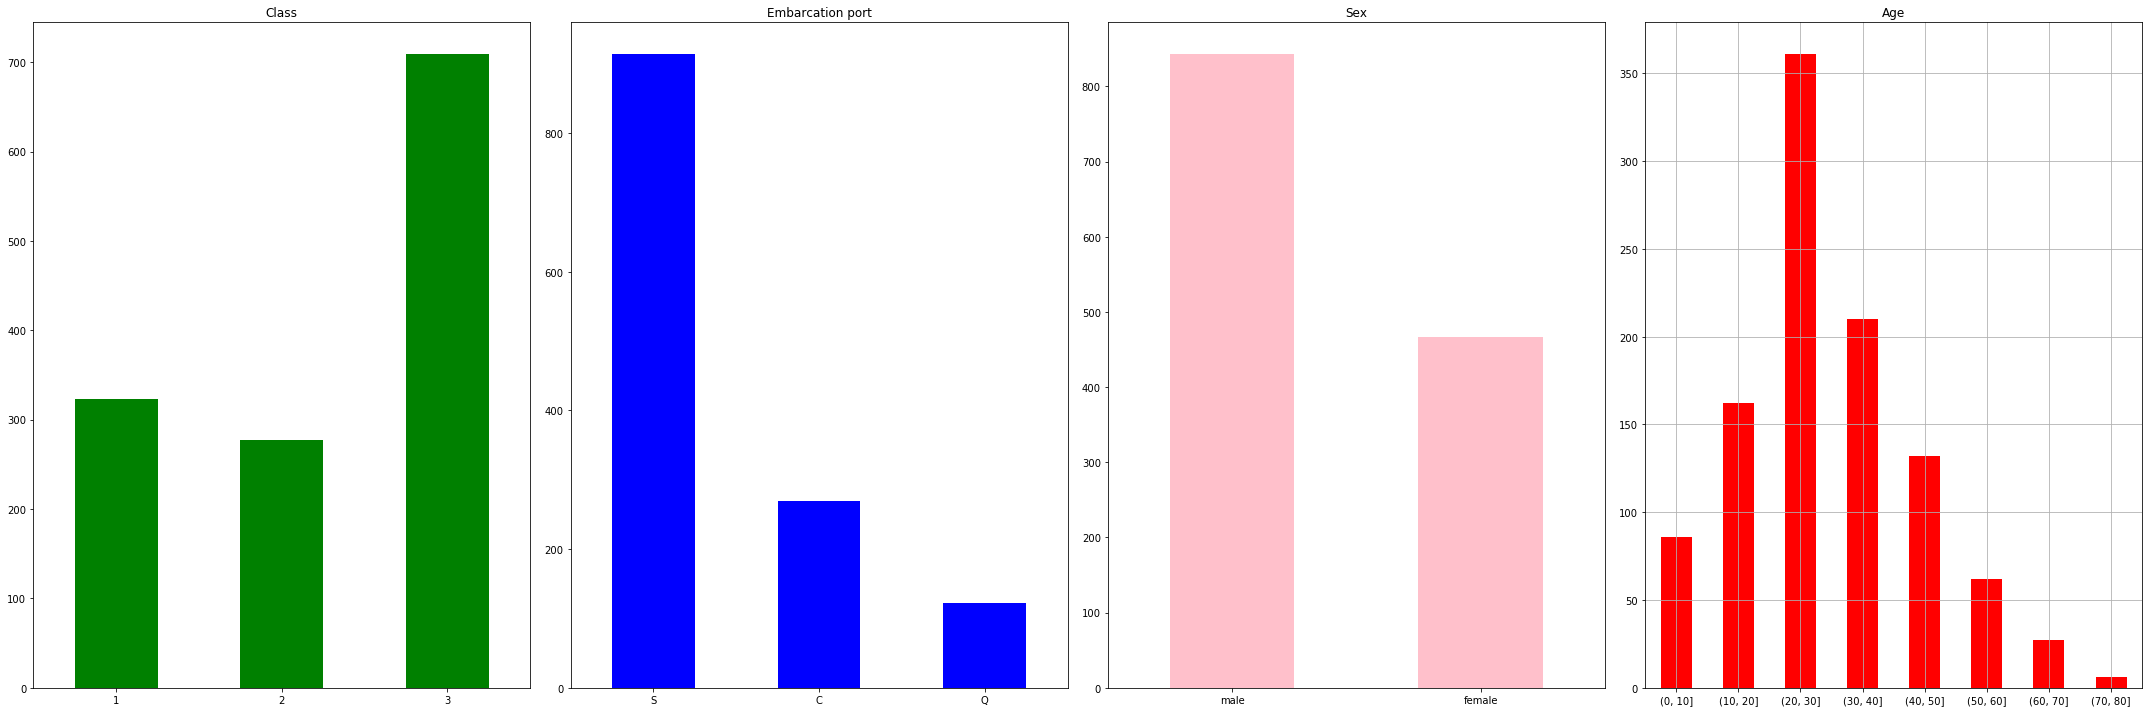

In [7]:
# Question 2

unused,subplots = plt.subplots(1,4, figsize=(30,10))

df['pclass'].value_counts(sort=False).plot(ax=subplots[0], kind='bar', title="Class", rot=0, color='green')
df['embarked'].value_counts(sort=True).plot(ax=subplots[1], kind='bar', title="Embarcation port", rot=0, color='blue')
df['sex'].value_counts(sort=True).plot(ax=subplots[2], kind='bar', title="Sex", rot=0, color='pink')
pd.cut(df['age'], [i for i in range(0, 90, 10)]).value_counts(sort=False).plot(ax=subplots[3], kind='bar', title="Age", rot=0, color='red', grid=True)
plt.tight_layout()

In [8]:
# Question 3

df['floor'] = df['cabin'].map(lambda x: x[0], na_action='ignore')
df['floor'].value_counts(sort=True).plot(kind='pie', title="Floor count", autopct='%i%%')

NotImplementedError: 

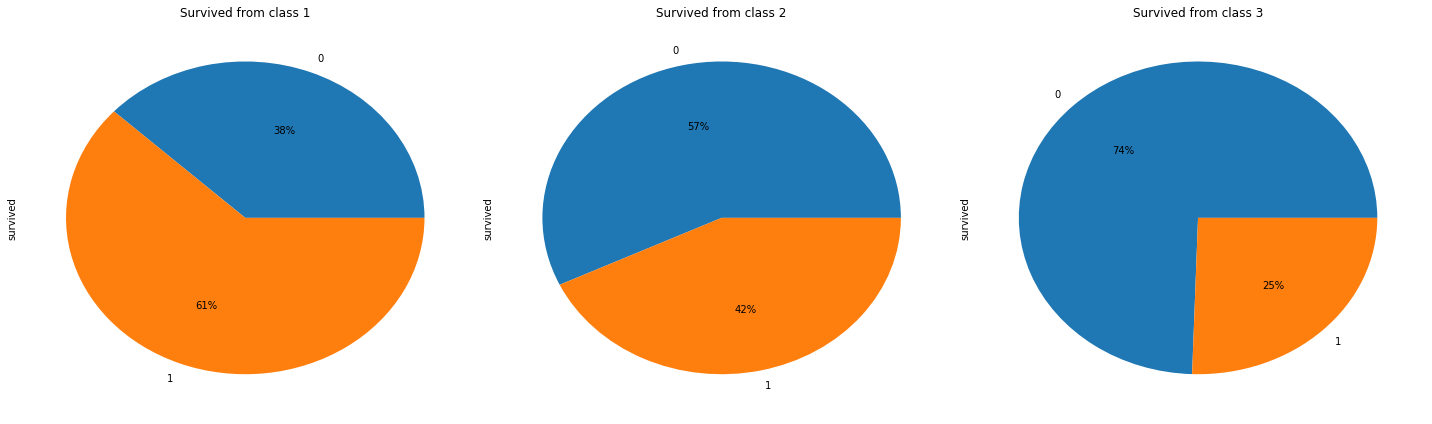

In [9]:
# Question 4

unused, subplots = plt.subplots(1,3, figsize=(20,6))
for i in range(1,4):
    df.query('pclass == @i')['survived'].value_counts(sort=False).plot(ax=subplots[i-1], kind='pie', title=("Survived from class " + str(i)), autopct='%i%%')
plt.tight_layout()

In [9]:
# Question 5
        
m_c1 = df.query('sex=="male" and pclass==1')['survived'].describe().loc['mean']*100
m_c2 = df.query('sex=="male" and pclass==2')['survived'].describe().loc['mean']*100
m_c3 = df.query('sex=="male" and pclass==3')['survived'].describe().loc['mean']*100

f_c1 = df.query('sex=="female" and pclass==1')['survived'].describe().loc['mean']*100
f_c2 = df.query('sex=="female" and pclass==2')['survived'].describe().loc['mean']*100
f_c3 = df.query('sex=="female" and pclass==3')['survived'].describe().loc['mean']*100


m = pd.DataFrame({'Male':[m_c1, m_c2, m_c3], 'Female':[f_c1, f_c2, f_c3]}, index=[1,2,3], columns=['Male', 'Female'])
m.plot(kind='bar', rot=0, label="e")
plt.xlabel('Class')
plt.ylabel('Percentage of survivors')

KeyError: 'the label [mean] is not in the [index]'

In [274]:
# Question 6

queries_young_middle_old = ['age < 27 or age > 57', 'age >= 27 and age <= 57']
queries_sex = ['sex=="male"', 'sex=="female"']
queries_class = ['pclass==1', 'pclass==2', 'pclass==3']

dt=[]
for q1 in queries_class:
    for q2 in queries_young_middle_old:
        for q3 in queries_sex:
            dt.append(str(int(df.query(q1+' and '+q2+' and '+q3)['survived'].describe().loc['mean']*100))+"%")
            
multIndex=[('Young/Old', 'Male'), ('Young/Old', 'Female'), ('Middle aged', 'Male'), ('Middle aged', 'Female')]
answer = pd.DataFrame(data={'Class 1': dt[:4],
                            'Class 2': dt[4:8],
                            'Class 3': dt[8:]},
                      index=pd.MultiIndex.from_tuples(multIndex),
                      columns=['Class 1', 'Class 2', 'Class 3'])
answer

Class 1 Class 2 Class 3
Young/Old   Male       54%     43%     28%
            Female     80%     58%     33%
Middle aged Male       35%      6%     14%
            Female     97%     88%     36%